In [ ]:
!pip install seaborn

In [ ]:
!pip install numpy pandas matplotlib scikit-learn flask


In [399]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [518]:
# food_data=pd.read_csv("D:/project/Nov Project/data/Food data with festivals.csv")
food_data=pd.read_csv("D:/project/Nov Project/data/Balaji Fast Food Sales.csv")

In [519]:
food_data.head()

,order_id,Date,Item Name,Category,Price,Quantity,Amount Transacted (?),Transaction Type,Gender,Time of Sale,Festival Name
0,1.0,07-03-2022,Aalopuri,Fastfood,20.0,13.0,260.0,NaN,Male,Night,NaN
1,2.0,8-23-2022,Vadapav,Fastfood,20.0,15.0,300.0,Cash,Male,Afternoon,NaN
2,3.0,11-20-2022,Vadapav,Fastfood,20.0,1.0,20.0,Cash,Male,Afternoon,NaN
3,4.0,02-03-2023,Sugarcane juice,Beverages,25.0,6.0,150.0,Online,Male,Night,NaN
4,5.0,10-02-2022,Sugarcane juice,Beverages,25.0,8.0,200.0,Online,Male,Evening,NaN


preprocessing


In [521]:
def standardize_date(date_str):
    if not isinstance(date_str, str):
        date_str = str(date_str)
    for fmt in ('%d/%m/%Y', '%d-%m-%Y', '%Y-%m-%d', '%Y/%m/%d'):
        try:
            return datetime.strptime(date_str, fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
    print(f"Date format error for: {date_str}")
    raise ValueError(f'No valid date format found for {date_str}')


food_data['Date'] = food_data['Date'].astype(str)

def apply_standardize_date(date_series):
    standardized_dates = []
    for date in date_series:
        try:
            standardized_dates.append(standardize_date(date))
        except ValueError as e:
            print(e)
            standardized_dates.append(None)
    return standardized_dates

food_data['Date'] = apply_standardize_date(food_data['Date'])


food_data = food_data.dropna(subset=['Date'])



In [512]:
na_dates = food_data['Date'].isna().sum()
print(f"Number of NaT (Not a Time) values: {na_dates}")

Number of NaT (Not a Time) values: 0


feature engineer

In [523]:
## 1. Extract the day of the week
food_data['Day'] = pd.to_datetime(food_data['Date']).dt.day_name()

## 2. Add Seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

food_data['Season'] = pd.to_datetime(food_data['Date']).dt.month.apply(get_season)

## 3. Add Is_weekend flag
food_data['Is_weekend'] = food_data['Day'].isin(['Saturday', 'Sunday'])

In [515]:
print("\nData after feature engineering:")
print(food_data.tail())


Data after feature engineering:
      order_id        Date    Item_Name   Category  Price  Quantity  \
986      987.0  2023-04-01      Vadapav   Fastfood   20.0       3.0   
987      988.0  2023-03-01      Frankie   Fastfood   50.0      13.0   
988      989.0  2022-11-10  Cold coffee  Beverages   40.0      13.0   
993      994.0  2022-01-11     Panipuri   Fastfood   20.0       2.0   
1000    1001.0  2021-08-05      khichdi   Fastfood   20.0       1.0   

      Amount Transacted (?) Transaction Type  Gender Time of Sale  \
986                    60.0             Cash  Female      Evening   
987                   650.0              NaN  Female        Night   
988                   520.0             Cash    Male    Afternoon   
993                    40.0           Online  Female      Evening   
1000                   20.0           Online  Female      Morning   

     Festival Name        Day  Season  Is_weekend  
986            NaN   Saturday  Spring        True  
987            NaN  W

In [524]:
import os
food_data.columns = food_data.columns.str.strip()

food_data['Date'] = pd.to_datetime(food_data['Date'], errors='coerce')
for col in ['Item Name', 'Category', 'Gender', 'Time of Sale', 'Festival Name']:
    if col in food_data.columns:
        food_data[col] = food_data[col].str.strip()

## Check for missing values
missing_summary = food_data.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)

## Strategy to handle missing values
# Numerical columns: Fill with mean
num_cols = food_data.select_dtypes(include=['float64', 'int64']).columns
food_data[num_cols] = food_data[num_cols].fillna(food_data[num_cols].mean())

# Categorical columns: Fill with 'Unknown' or mode
cat_cols = food_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    food_data[col] = food_data[col].fillna(food_data[col].mode()[0])

## Drop rows with missing dates if any
food_data = food_data.dropna(subset=['Date','Item Name','Category','Quantity'])

print("Preview of Cleaned Data:")
food_data.head()

Missing Values Summary:
order_id                   0
Date                       0
Item Name                  0
Category                   0
Price                      0
Quantity                   0
Amount Transacted (?)      0
Transaction Type          38
Gender                     0
Time of Sale               0
Festival Name            359
Day                        0
Season                     0
Is_weekend                 0
dtype: int64
Preview of Cleaned Data:


,order_id,Date,Item Name,Category,Price,Quantity,Amount Transacted (?),Transaction Type,Gender,Time of Sale,Festival Name,Day,Season,Is_weekend
0,1.0,2022-03-07,Aalopuri,Fastfood,20.0,13.0,260.0,Cash,Male,Night,Mahashivratri,Monday,Spring,False
3,4.0,2023-03-02,Sugarcane juice,Beverages,25.0,6.0,150.0,Online,Male,Night,Mahashivratri,Thursday,Spring,False
4,5.0,2022-02-10,Sugarcane juice,Beverages,25.0,8.0,200.0,Online,Male,Evening,Mahashivratri,Thursday,Winter,False
6,7.0,2022-03-05,Sugarcane juice,Beverages,25.0,9.0,225.0,Cash,Male,Evening,Mahashivratri,Saturday,Spring,True
8,9.0,2022-10-06,Panipuri,Fastfood,20.0,1.0,20.0,Cash,Female,Morning,Mahashivratri,Thursday,Autumn,False


data visualization


clustering

In [527]:
food_data.rename(columns={
    'Item Name': 'Item_Name', 
    'Amount Transacted (₹)': 'Amount_Transacted_(₹)',
    'Transaction Type' : 'Transaction_Type',
    'Time of Sale' : 'Time_of_Sale',
    'Festival Name' : 'Festival_Name'
    }, inplace=True)

In [528]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


In [529]:
data_encoded = food_data.copy()
label_encoders = {}
for column in ['Time_of_Sale','Category', 'Item_Name', 'Day', 'Gender','Festival_Name']:
    le = LabelEncoder()
    data_encoded[column] = le.fit_transform(data_encoded[column])
    label_encoders[column] = le
    
data_encoded.head()

,order_id,Date,Item_Name,Category,Price,Quantity,Amount Transacted (?),Transaction_Type,Gender,Time_of_Sale,Festival_Name,Day,Season,Is_weekend
0,1.0,2022-03-07,0,1,20.0,13.0,260.0,Cash,1,4,10,1,Spring,False
3,4.0,2023-03-02,5,0,25.0,6.0,150.0,Online,1,4,10,4,Spring,False
4,5.0,2022-02-10,5,0,25.0,8.0,200.0,Online,1,1,10,4,Winter,False
6,7.0,2022-03-05,5,0,25.0,9.0,225.0,Cash,1,1,10,2,Spring,True
8,9.0,2022-10-06,3,1,20.0,1.0,20.0,Cash,0,3,10,4,Autumn,False


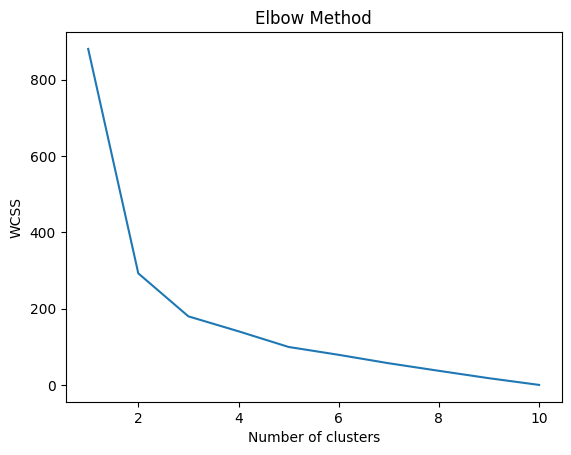


 Total number of clusters: 4
<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 0 to 1000
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               404 non-null    float64       
 1   Date                   404 non-null    datetime64[ns]
 2   Item_Name              404 non-null    object        
 3   Category               404 non-null    object        
 4   Price                  404 non-null    float64       
 5   Quantity               404 non-null    float64       
 6   Amount Transacted (?)  404 non-null    float64       
 7   Transaction_Type       404 non-null    object        
 8   Gender                 404 non-null    object        
 9   Time_of_Sale           404 non-null    object        
 10  Festival_Name          404 non-null    object        
 11  Day                    404 non-null    object        
 12  Season                 404 non-null   

In [530]:
# Selecting relevant features
X = data_encoded[['Time_of_Sale', 'Gender']]
# Determine optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit K-Means with optimal number of clusters
optimal_clusters = 4  # Replace with the determined number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
food_data['Cluster'] = kmeans.fit_predict(X)

# Print total number of clusters
print(f"\n Total number of clusters: {optimal_clusters}")

food_data.info()

1. random forest


In [531]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [532]:
food_data.drop(['Cluster','Is_weekend','Season'],axis=1,inplace=True)
food_data.head()

,order_id,Date,Item_Name,Category,Price,Quantity,Amount Transacted (?),Transaction_Type,Gender,Time_of_Sale,Festival_Name,Day
0,1.0,2022-03-07,Aalopuri,Fastfood,20.0,13.0,260.0,Cash,Male,Night,Mahashivratri,Monday
3,4.0,2023-03-02,Sugarcane juice,Beverages,25.0,6.0,150.0,Online,Male,Night,Mahashivratri,Thursday
4,5.0,2022-02-10,Sugarcane juice,Beverages,25.0,8.0,200.0,Online,Male,Evening,Mahashivratri,Thursday
6,7.0,2022-03-05,Sugarcane juice,Beverages,25.0,9.0,225.0,Cash,Male,Evening,Mahashivratri,Saturday
8,9.0,2022-10-06,Panipuri,Fastfood,20.0,1.0,20.0,Cash,Female,Morning,Mahashivratri,Thursday


In [564]:
food_data.drop(['Season'],axis=1,inplace=True)

In [565]:
food_data['Month'] = pd.to_datetime(food_data['Date']).dt.month
food_data.head()

,order_id,Date,Item_Name,Category,Price,Quantity,Amount Transacted (?),Transaction_Type,Gender,Time_of_Sale,Festival_Name,Day,Month
0,1.0,2022-03-07,Aalopuri,Fastfood,20.0,13.0,260.0,Cash,Male,Night,Mahashivratri,Monday,3
3,4.0,2023-03-02,Sugarcane juice,Beverages,25.0,6.0,150.0,Online,Male,Night,Mahashivratri,Thursday,3
4,5.0,2022-02-10,Sugarcane juice,Beverages,25.0,8.0,200.0,Online,Male,Evening,Mahashivratri,Thursday,2
6,7.0,2022-03-05,Sugarcane juice,Beverages,25.0,9.0,225.0,Cash,Male,Evening,Mahashivratri,Saturday,3
8,9.0,2022-10-06,Panipuri,Fastfood,20.0,1.0,20.0,Cash,Female,Morning,Mahashivratri,Thursday,10


In [566]:
# Assuming food_data is your dataset

# Select the features (X) and target variable (y)
# Drop the 'Date' column and add the extracted datetime features
X = food_data.drop(columns=['order_id','Quantity', 'Date'])  
y = food_data['Quantity']  # Target variable is 'Quantity'


In [567]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [568]:
X_train.head()

,Item_Name,Category,Price,Amount Transacted (?),Transaction_Type,Gender,Time_of_Sale,Festival_Name,Day,Month
877,Sandwich,Fastfood,60.0,360.0,Online,Male,Evening,Mahashivratri,Thursday,12
581,Aalopuri,Fastfood,20.0,260.0,Cash,Male,Morning,Mahashivratri,Monday,12
6,Sugarcane juice,Beverages,25.0,225.0,Cash,Male,Evening,Mahashivratri,Saturday,3
36,Frankie,Fastfood,50.0,500.0,Cash,Male,Night,Mahashivratri,Monday,5
302,Sugarcane juice,Beverages,25.0,25.0,Cash,Female,Midnight,Mahashivratri,Monday,2


In [569]:
# Example categorical columns
# Update the categorical columns list
categorical_columns = ['Item_Name', 'Category', 'Time_of_Sale', 'Festival_Name', 'Day']
# Identify numerical columns
numerical_columns = ['Price', 'Amount Transacted (?)','Month']

# Column transformer to one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values in numerical columns
            ('scaler', StandardScaler())  # Standardize numerical columns
        ]), numerical_columns),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values in categorical columns
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding categorical columns
        ]), categorical_columns)
    ])


In [ ]:
# # Example categorical columns
# # Update the categorical columns list
# categorical_columns = ['Item_Name', 'Category', 'Time_of_Sale', 'Festival_Name', 'Day']
# # Identify numerical columns
# numerical_columns = ['Price','Amount_Transacted_(₹)']

# # Column transformer to one-hot encode categorical columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline([
#             ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values in numerical columns
#             ('scaler', StandardScaler())  # Standardize numerical columns
#         ]), numerical_columns),
        
#         ('cat', Pipeline([
#             ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values in categorical columns
#             ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding categorical columns
#         ]), categorical_columns)
#     ])


In [570]:
# Create a Random Forest Regressor model
model_random=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [539]:
X_train.dtypes

Item_Name                 object
Category                  object
Price                    float64
Amount Transacted (?)    float64
Transaction_Type          object
Gender                    object
Time_of_Sale              object
Festival_Name             object
Day                       object
dtype: object

In [353]:
y_train.head()

331    1
409    1
76     4
868    1
138    3
Name: Quantity, dtype: int64

In [571]:
# Train the model
model_random.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Price',
                                                   'Amount Transacted (?)',
                                                   'Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Item_Name', 'Category',
                                                   'Time_of_Sale',
                                                   'Festival_Name', 'Day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [572]:
# Train the model
model_random.fit(X_train, y_train)

# Make predictions
y_pred = model_random.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'R² (R-squared) value: {r2}')

Mean Absolute Error: 0.19419753086419744
R² (R-squared) value: 0.9927254356665699


prediction

In [67]:
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               1200 non-null   int64         
 1   Date                   1200 non-null   datetime64[ns]
 2   Item_Name              1200 non-null   object        
 3   Category               1200 non-null   object        
 4   Price                  1200 non-null   int64         
 5   Quantity               1200 non-null   int64         
 6   Amount_Transacted_(₹)  1200 non-null   int64         
 7   Transaction_Type       1200 non-null   object        
 8   Gender                 1200 non-null   object        
 9   Time_of_Sale           0 non-null      object        
 10  Festival_Name          1200 non-null   object        
 11  Day                    1200 non-null   object        
 12  Season                 1200 non-null   object        
 13  Is_

In [553]:
# Example user input
user_date = input("Enter the date (YYYY-MM-DD): ")

In [555]:
# Define item types and item names
item_types = ['Fastfood', 'Beverages']
item_names_fastfood = [
    "Sabudana Khichdi", "Sabudana Vada", "Sabudana Wada", "Sada Dosa", 
    "Sambar Vada", "Samosa", "Samosa Chaat", "Sevpuri", "Shrikhand", 
    "Suji Halwa", "Sweets Mithai", "Tandoori Chicken", "Upma", "Uttapam", 
    "Vada", "Vada Pav", "Veg Pulao", "Veg Thali", "Pakoda", 
    "Paneer Butter Masala", "Paneer Tikka", "Pani Puri", "Paratha", 
    "Pav Bhaji", "Pesarattu", "Poha", "Puddings", "Puran Poli", 
    "Puranpoli", "Ragda Pattice", "Rajma", "Rajma Chawal", "Rasam", 
    "Rasgulla", "Rasmalai", "Roti", "Idli Vada", "Jain Thali", "Jalebi", 
    "Kachori", "Kathi Roll", "Kheer", "Kulfi", "Masala Dosa", 
    "Masala Uttapam", "Meat Thali", "Medu Vada", "Misal Pav", "Momos", 
    "Mung Dal Ka Halwa", "Mutton Rogan Josh", "Naan", "Onion Pakoda", 
    "Onion Uttapam", "Aloo Paratha", "Aloo Puri", "Aloo Tikki", "Bhel Puri", "Biryani",
    "Bread Pakora", "Brownies", "Butter Chicken", "Butter Naan", "Cakes",
    "Chapati", "Chicken Biryani", "Chicken Sandwich", "Chicken Shawarma",
    "Chicken Thali", "Chicken Tikka Masala", "Chilli Paneer",'Aalopuri', 'Frankie', 'Panipuri', 'Vadapav'
]
item_names_beverages = [
    "Bitter Gourd Juice", "Butter Milk", "Chai", "Coffee", "Cold Coffee",
    "Cold Drink (Coke)", "Cold Drink (Fanta)", "Cold Drink (Peach)", 
    "Cold Drink (Pepsi)", "Cold Drink (Sprite)", "Cold Drink (Thumbs Up)",
    "Falooda", "Filter Coffee", "Ginger Tea", "Green Tea", "Hot Chocolate", 
    "Ice Cream", "Ice Cream (Butterscotch)", "Ice Cream (Chocolate)", 
    "Ice Cream (Strawberry)", "Ice Cream (Vanilla)", "Iced Tea", "Kheer", 
    "Lassi", "Lemon Tea", "Mango Lassi", "Masala Chai", "Masala Tea", 
    "Nimbu Pani", "Samosa", "Shirkurma", "Sweet Lassi", "Sweets", 
    "Tea", "Thandai",'Sugarcane juice'
]
transation_type=['Cash','Online']
gender_types=['Female','Male']
amot_transaction='1000'
# Generate all combinations of time_of_sale and item_type
times_of_sale = ['Morning', 'Afternoon', 'Evening', 'Night']
item_names = item_names_fastfood + item_names_beverages
# Create a DataFrame with all combinations
df_input = pd.DataFrame(
    [(time, item_type, item_name,tra_type,gender_type)
     for time in times_of_sale
     for item_type in item_types
     for tra_type in transation_types
     for gender_type in gender_types
     for item_name in item_names if (item_type == 'Beverages' and item_name in item_names_beverages) or (item_type == 'Fastfood' and item_name in item_names_fastfood)],
    columns=['time_of_sale', 'item_type', 'item_name','transcation_type', 'gender_type']
)
df_input['day'] = input_day
df_input['transcation_amount'] = amot_transaction

In [ ]:
import random

# Function to extract features for a user-given day
def prepare_input(user_date, food_data):
    if isinstance(user_date, datetime):
        user_date = user_date.strftime('%Y-%m-%d')  
    user_date = datetime.strptime(user_date, '%Y-%m-%d')  # Parse the user input date
    day_name = user_date.strftime('%A')  # Get the day name (e.g., Monday)
    user_input_month= user_date.strftime('%m')
    
    # Check if the date is a festival (based on the dataset)
    festival_info = food_data.loc[food_data['Date'] == user_date, 'Festival_Name']
    festival_name = festival_info.values[0] if not festival_info.empty else 'None'
    
    # Randomly select an Item_Name for prediction
    item_name = random.choice(item_names)  # Choose one item from the combined list
    
    # Determine Category based on the selected item
    category = 'Fastfood' if item_name in item_names_fastfood else 'Beverages'
    
    # Create a sample input row for prediction
    sample_input = {
        'Price': 0,  # Placeholder (fill dynamically)
        'Amount Transacted (?)': 0,  # Placeholder
        'Item_Name': item_name,  # Selected item
        'Category': category,  # Category based on the item
        'Time_of_Sale': 'Unknown',  # Placeholder
        'Festival_Name': festival_name,
        'Day': day_name,
        'Month':user_input_month
        
    }
    return sample_input

In [ ]:


def predict_quantities_for_day(user_date, food_data, model):
    user_input = prepare_input(user_date, food_data)
    predicted_quantities = []
    
    # Iterate through predefined item names
    for item_name in item_names:
        user_input['Item_Name'] = item_name
        user_input['Category'] = 'Fastfood' if item_name in item_names_fastfood else 'Beverages'
        
        # Duplicate input to represent all sales slots
        time_slots = food_data['Time_of_Sale'].unique()
        for slot in time_slots:
            user_input['Time_of_Sale'] = slot
            
            # Convert input to DataFrame for prediction
            input_df = pd.DataFrame([user_input])
            quantity_pred = model.predict(input_df)[0]
            predicted_quantities.append({
                'Time_Slot': slot,
                'Item_Name': item_name,
                'Category': user_input['Category'],
                'Predicted_Quantity': round(quantity_pred, 2)
            })
    return pd.DataFrame(predicted_quantities)




# Predict quantities
predicted_table = predict_quantities_for_day(user_date, food_data, model_random)

# Display the predictions
print("Predicted Food Quantities for", user_date)
print(predicted_table)




Predicted Food Quantities for 2024-11-25 00:00:00
     Time_Slot         Item_Name   Category  Predicted_Quantity
0        Night  Sabudana Khichdi   Fastfood                 1.0
1      Evening  Sabudana Khichdi   Fastfood                 1.0
2      Morning  Sabudana Khichdi   Fastfood                 1.0
3    Afternoon  Sabudana Khichdi   Fastfood                 1.0
4     Midnight  Sabudana Khichdi   Fastfood                 1.0
..         ...               ...        ...                 ...
550      Night   Sugarcane juice  Beverages                 1.0
551    Evening   Sugarcane juice  Beverages                 1.0
552    Morning   Sugarcane juice  Beverages                 1.0
553  Afternoon   Sugarcane juice  Beverages                 1.0
554   Midnight   Sugarcane juice  Beverages                 1.0

[555 rows x 4 columns]


In [579]:
def predict_quantities_by_time_slots(user_date, food_data, model):
    user_input = prepare_input(user_date, food_data)
    all_predictions = []
    
    
    # Iterate through predefined item names
    for item_name in item_names:
        user_input['Item_Name'] = item_name
        user_input['Category'] = 'Fastfood' if item_name in item_names_fastfood else 'Beverages'
        
        # Duplicate input to represent all sales slots
        time_slots = ['Morning', 'Afternoon', 'Evening', 'Night']
        for slot in time_slots:
            user_input['Time_of_Sale'] = slot
            
            # Convert input to DataFrame for prediction
            input_df = pd.DataFrame([user_input])
            quantity_pred = model_random.predict(input_df)[0]
            
            # Append prediction details
            all_predictions.append({
                'Time_Slot': slot,
                'Item_Name': item_name,
                'Category': user_input['Category'],
                'Predicted_Quantity': round(quantity_pred, 2)
            })
    
    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame(all_predictions)

    # Separate tables for each time slot
    time_slot_tables = {}
    for slot in ['Morning', 'Afternoon', 'Evening', 'Night']:
        time_slot_tables[slot] = predictions_df[predictions_df['Time_Slot'] == slot].reset_index(drop=True)
    
    return time_slot_tables


In [580]:
# User inputs the date
user_date = '2024-11-22'

# Call the function to get time-slot-wise tables
time_slot_tables = predict_quantities_by_time_slots(user_date, food_data, model_random)

# Display tables for each time slot
for slot, table in time_slot_tables.items():
    print(f"\nPredictions for {slot}:\n")
    print(table)



Predictions for Morning:

    Time_Slot         Item_Name   Category  Predicted_Quantity
0     Morning  Sabudana Khichdi   Fastfood                 1.0
1     Morning     Sabudana Vada   Fastfood                 1.0
2     Morning     Sabudana Wada   Fastfood                 1.0
3     Morning         Sada Dosa   Fastfood                 1.0
4     Morning       Sambar Vada   Fastfood                 1.0
..        ...               ...        ...                 ...
106   Morning       Sweet Lassi  Beverages                 1.0
107   Morning            Sweets  Beverages                 1.0
108   Morning               Tea  Beverages                 1.0
109   Morning           Thandai  Beverages                 1.0
110   Morning   Sugarcane juice  Beverages                 1.0

[111 rows x 4 columns]

Predictions for Afternoon:

     Time_Slot         Item_Name   Category  Predicted_Quantity
0    Afternoon  Sabudana Khichdi   Fastfood                 1.0
1    Afternoon     Sabudana Vada   F

In [581]:
def aggregate_predictions_by_item(user_date, food_data, model):
    user_input = prepare_input(user_date, food_data)
    all_predictions = []

    # Iterate through predefined item names
    for item_name in item_names:
        user_input['Item_Name'] = item_name
        user_input['Category'] = 'Fastfood' if item_name in item_names_fastfood else 'Beverages'
        
        # Duplicate input to represent all sales slots
        time_slots = ['Morning', 'Afternoon', 'Evening', 'Night']
        for slot in time_slots:
            user_input['Time_of_Sale'] = slot
            
            # Convert input to DataFrame for prediction
            input_df = pd.DataFrame([user_input])
            quantity_pred = model_random.predict(input_df)[0]
            
            # Append prediction details
            all_predictions.append({
                'Time_Slot': slot,
                'Item_Name': item_name,
                'Category': user_input['Category'],
                'Predicted_Quantity': quantity_pred
            })
    
    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame(all_predictions)

    # Group by Item_Name and Category to sum the Predicted_Quantity
    aggregated_table = (
        predictions_df.groupby(['Item_Name', 'Category'])
        .agg({'Predicted_Quantity': 'sum'})
        .reset_index()
        .rename(columns={'Predicted_Quantity': 'Total_Predicted_Quantity'})
    )

    return aggregated_table

# Call the function and display the result
user_date = '2024-11-22'
aggregated_table = aggregate_predictions_by_item(user_date, food_data, model_random)

# Display the aggregated table
print("\nAggregated Predictions:\n")
print(aggregated_table)



Aggregated Predictions:

        Item_Name  Category  Total_Predicted_Quantity
0        Aalopuri  Fastfood                      4.00
1    Aloo Paratha  Fastfood                      4.00
2       Aloo Puri  Fastfood                      4.00
3      Aloo Tikki  Fastfood                      4.00
4       Bhel Puri  Fastfood                      4.00
..            ...       ...                       ...
104          Vada  Fastfood                      4.00
105      Vada Pav  Fastfood                      4.00
106       Vadapav  Fastfood                      4.06
107     Veg Pulao  Fastfood                      4.00
108     Veg Thali  Fastfood                      4.00

[109 rows x 3 columns]
